In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import exp1

In [2]:
from google.colab import drive
drive.mount('/content/drive')
datos = pd.read_csv('/content/drive/MyDrive/data_txt.txt', delimiter='\t', header=None)
datos_obs = tf.constant(datos.iloc[:, 0], dtype=tf.float64)
datos_t= tf.Variable(datos.iloc[:, 1], dtype=tf.float64)
print(datos_t)

Mounted at /content/drive
<tf.Variable 'Variable:0' shape=(34,) dtype=float64, numpy=
array([1.00e-01, 2.50e-01, 5.00e-01, 7.00e-01, 1.00e+00, 1.40e+00,
       1.90e+00, 2.33e+00, 2.80e+00, 3.36e+00, 4.00e+00, 5.35e+00,
       6.80e+00, 8.30e+00, 8.70e+00, 1.00e+01, 1.31e+01, 1.80e+01,
       2.70e+01, 3.30e+01, 4.10e+01, 4.80e+01, 5.90e+01, 8.00e+01,
       9.50e+01, 1.39e+02, 1.81e+02, 2.45e+02, 3.00e+02, 3.60e+02,
       4.80e+02, 6.00e+02, 7.28e+02, 8.30e+02])>


In [3]:
@tf.function
def FM_theis(T, S):
    """
    Función de la ecuación de Theis

    Parámetros:
    -- T: float o tensor de tensorflow, transmisividad (m^2/s)
    -- S: float o tensor de tensorflow, almacenamiento (adimensional)

    Retorna:
    -- s: tensor de tensorflow, abatimiento (m) correspondiente a cada valor de r2_t
    """

    Q = 788/1440
    r = 30
    pi = tf.constant(np.pi, dtype=tf.float64)

    u = (r**2 * S) / (4 * T * datos_t)
    W_u = tf.exp(-u) * tf.numpy_function(exp1, [u], tf.float64)

    # Calcular el abatimiento s
    s = (Q / (4 * pi * T)) * W_u

    return s

In [4]:
optimizer = tf.keras.optimizers.Adafactor(learning_rate=0.01)

In [5]:
HG = tf.Module()
HG.T = tf.Variable(1., dtype=tf.float64)
HG.S = tf.Variable(1., dtype=tf.float64)

In [6]:
def train():
    with tf.GradientTape() as tape:
      datos_pred = FM_theis(HG.T, HG.S)
      J = (1/len(datos_obs)) * tf.reduce_mean(tf.square(datos_pred - datos_obs))
    grads = tape.gradient(J, HG.trainable_variables)
    optimizer.apply_gradients(zip(grads, HG.trainable_variables))
    return J

In [7]:
from tqdm import trange
loss_i = []
niter = trange(1000)
for i in niter:
  loss = train()
  niter.set_postfix(LOSS=loss.numpy())
  loss_i.append(loss.numpy())

100%|██████████| 1000/1000 [00:21<00:00, 46.73it/s, LOSS=2.62e-5]


LOSS: 2.6171186069590007e-05


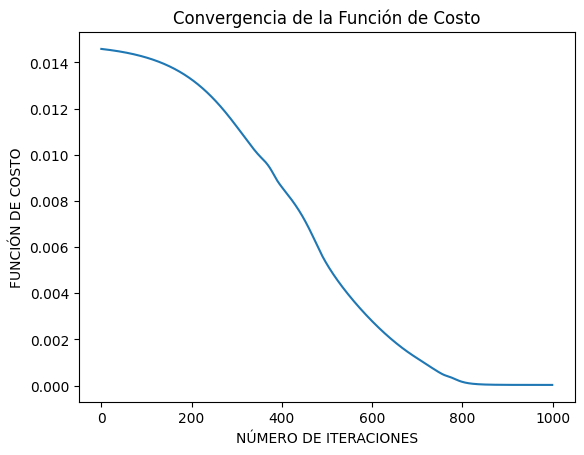

In [8]:
plt.plot(loss_i)
plt.title('Convergencia de la Función de Costo')
plt.ylabel('FUNCIÓN DE COSTO')
plt.xlabel('NÚMERO DE ITERACIONES')
print(f'LOSS: {loss}')

In [9]:
resultados_FM = FM_theis(HG.T, HG.S)
ind_x = tf.constant(np.argsort(datos_t.numpy()))
x = tf.gather(datos_t, ind_x)
resultados_ind_x = tf.gather(resultados_FM, ind_x)

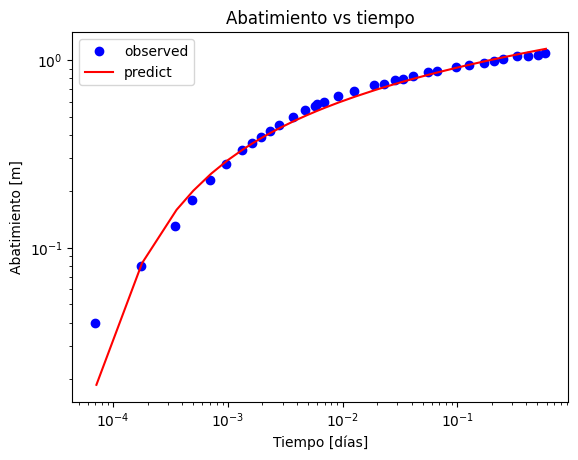

In [10]:
plt.plot(datos_t/1440, datos_obs, 'bo', label='observed')
plt.plot(x/1400, resultados_ind_x, '-', label = 'predict', color = 'red')
plt.xlabel('Tiempo [días]')
plt.ylabel('Abatimiento [m]')
plt.xscale('log')
plt.yscale('log')
plt.title('Abatimiento vs tiempo')
plt.gca().patch.set_visible(False)
plt.savefig('/content/Parametros_hidro.svg', format='svg', transparent=True)
plt.legend()

In [11]:
from google.colab import files
files.download('/content/Parametros_hidro.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
print(f'T: {HG.T.numpy()} [m^2/min]')
print(f'T: {HG.T.numpy() * 1440} [m^2/día]')
print(f'S: {HG.S.numpy():.5e}')
print(f'Datos_pred: {np.sort(resultados_FM)}')

T: 0.32908738488959277 [m^2/min]
T: 473.8858342410136 [m^2/día]
S: 1.16564e-04
Datos_pred: [0.01862571 0.08284204 0.15936284 0.20149404 0.2480988  0.29312157
 0.33444082 0.36215696 0.38714787 0.41194394 0.43563954 0.47509699
 0.5075611  0.53448589 0.54083571 0.55960609 0.59592998 0.63856196
 0.69280585 0.71959675 0.74854109 0.76953957 0.79700361 0.83749089
 0.8603229  0.91085001 0.94587514 0.98601864 1.01286151 1.0370209
 1.07513224 1.10468715 1.13029497 1.14765783]
